# Importing Required Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.optim.optimizer
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
from tqdm import tqdm
import concurrent.futures
from torch.utils.data import random_split
from sklearn.metrics import classification_report, f1_score

print(torch.__version__)

2.5.1+cu121


In [4]:
def seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Seed for hash-based operations
    np.random.seed(seed)                      # Seed for NumPy
    torch.manual_seed(seed)                   # Seed for PyTorch (CPU)
    torch.cuda.manual_seed(seed)              # Seed for PyTorch (GPU)
    torch.backends.cudnn.deterministic = True # Make CuDNN deterministic
    torch.backends.cudnn.benchmark = True     # Enable benchmark mode for CuDNN

In [6]:
seed(19071591)

# EDA (Exploratory Data Analysis)

In [7]:
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

In [8]:
train_df= pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
train_df["filename"] = train_df["id_code"].map(lambda x:os.path.join("train_images",x+".png"))
test_df= pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [9]:
print('Number of train samples: ', train_df.shape[0])
print('Number of test samples: ', test_df.shape[0])
display(train_df.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis,filename
0,000c1434d8d7,2,train_images/000c1434d8d7.png
1,001639a390f0,4,train_images/001639a390f0.png
2,0024cdab0c1e,1,train_images/0024cdab0c1e.png
3,002c21358ce6,0,train_images/002c21358ce6.png
4,005b95c28852,0,train_images/005b95c28852.png


In [10]:
train_df['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

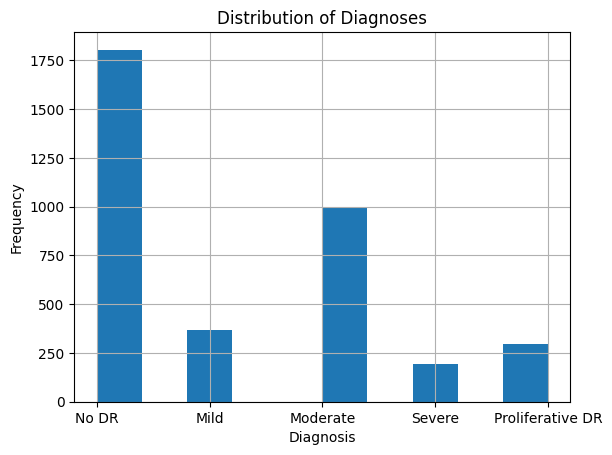

In [11]:
train_df.diagnosis.hist()
plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.xticks(range(5), class_labels)
plt.show()

In [12]:
train_dfDDR= pd.read_csv('../input/ddr-dataset/DDR dataset/train.csv')
train_dfDDR["filename"] = train_dfDDR["id_code"].map(lambda x:os.path.join("train_images",x+".png"))

In [13]:
print('Number of train samples: ', train_dfDDR.shape[0])
display(train_dfDDR.head())

Number of train samples:  1779


,id_code,diagnosis,filename
0,007-2809-100,1,train_images/007-2809-100.png
1,007-2811-100,1,train_images/007-2811-100.png
2,007-2812-100,1,train_images/007-2812-100.png
3,007-2814-100,1,train_images/007-2814-100.png
4,007-2815-100,1,train_images/007-2815-100.png


In [14]:
train_dfDDR['diagnosis'].value_counts()

diagnosis
4    913
1    630
3    236
Name: count, dtype: int64

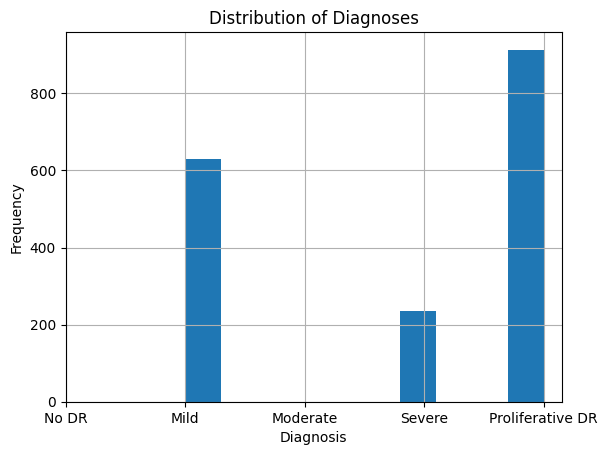

In [15]:
train_dfDDR.diagnosis.hist()
plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.xticks(range(5), class_labels)
plt.show()

In [ ]:
"""import shutil
output_dir = "/kaggle/working/"
dataset_dir = os.path.join(output_dir, "train_images")
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

aptos_dir = "../input/aptos2019-blindness-detection/train_images"
ddr_dir = "../input/ddr-dataset/DDR dataset/train_images"

aptos_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
aptos_df["filename"] = aptos_df["id_code"].map(lambda x:os.path.join(aptos_dir,x+".png"))

ddr_df = pd.read_csv('../input/ddr-dataset/DDR dataset/train.csv')
ddr_df["filename"] = ddr_df["id_code"].map(lambda x:os.path.join(ddr_dir,x+".png"))

for index, row in aptos_df.iterrows():
    src_path = row["filename"]
    dst_path = os.path.join(dataset_dir, os.path.basename(src_path))
    if os.path.exists(src_path):
      shutil.copy(src_path, dst_path)

for index, row in ddr_df.iterrows():
    src_path = row["filename"]
    dst_path = os.path.join(dataset_dir, os.path.basename(src_path))
    if os.path.exists(src_path):
      shutil.copy(src_path, dst_path)

merged_df = pd.concat([aptos_df, ddr_df], ignore_index=True)
merged_df.to_csv('/kaggle/working/train.csv', index=False)

print("Sao chép ảnh hoàn tất!")"""

In [ ]:
"""!cd /kaggle/working/
!zip -r datasets-dr.zip train_images train.csv

from IPython.display import FileLink
FileLink(r'datasets-dr.zip')"""

In [16]:
train_df= pd.read_csv('../input/datasets-dr/Datasets/train.csv')
train_df["filename"] = train_df["id_code"].map(lambda x:os.path.join("train_images",x+".png"))
test_df= pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

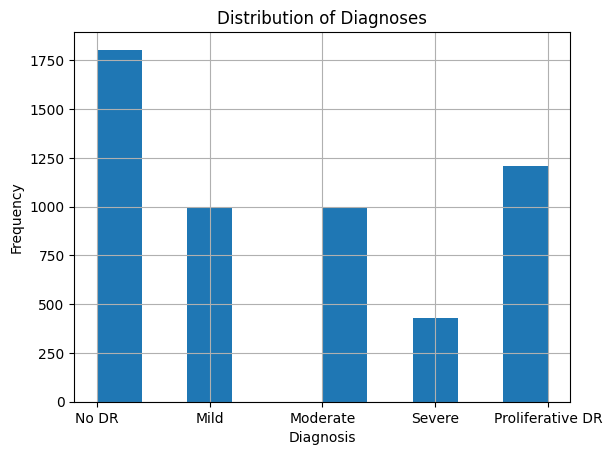

In [17]:
train_df.diagnosis.hist()
plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.xticks(range(5), class_labels)
plt.show()

In [18]:
print('Number of train samples: ', train_df.shape[0])
train_df['diagnosis'].value_counts()

Number of train samples:  5441


diagnosis
0    1805
4    1208
1    1000
2     999
3     429
Name: count, dtype: int64

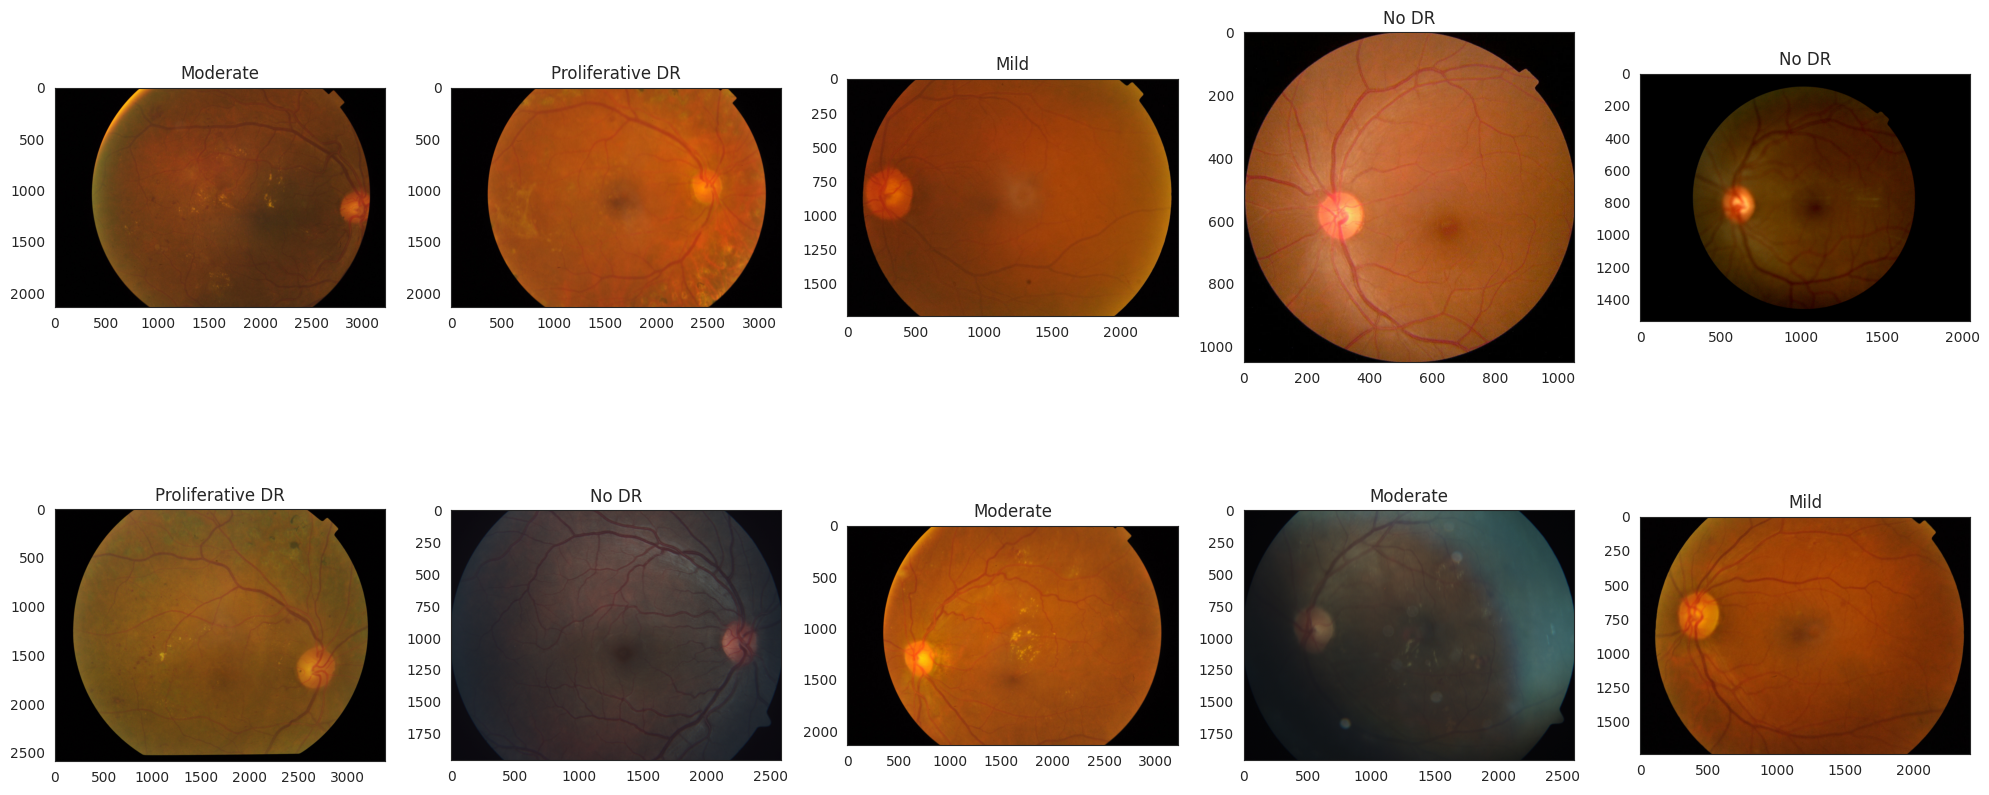

In [19]:
sns.set_style("white")
figure, ax = plt.subplots(2,5, figsize=(20, 12))
ax = ax.flatten()
for i,row in train_df.iloc[0:10,:].iterrows():
    image = cv2.imread(os.path.join("../input/datasets-dr/Datasets/train_images",row["id_code"]+".png"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].imshow(image)
    ax[i].set_title(label_title[str(row["diagnosis"])])
    plt.tight_layout()

# Data Preprocessing

In [20]:
def crop_image(image, tol = 7):
    if image.ndim == 2:
        mask = image > tol
        return image[np.ix_(mask.any(1), mask.any(0))]
    elif image.ndim == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = image_gray > tol
        check_shape = image[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if(check_shape == 0):
            return image
        else:
            image1 = image [:,:,0][np.ix_(mask.any(1), mask.any(0))]
            image2 = image [:,:,1][np.ix_(mask.any(1), mask.any(0))]
            image3 = image [:,:,2][np.ix_(mask.any(1), mask.any(0))]
            image = np.stack([image1, image2, image3], axis = -1)
        return image

def add_black_padding_and_resize(image, img_size):
    h, w = image.shape[:2]
    new_h, new_w = img_size, img_size
    if h > w:
        scale_factor = img_size / h
    else:
        scale_factor = img_size / w

    new_h = int(h * scale_factor)
    new_w = int(w * scale_factor)
    resized_image = cv2.resize(image, (new_w, new_h))
    top = (img_size - new_h) // 2
    bottom = img_size - new_h - top
    left = (img_size - new_w) // 2
    right = img_size - new_w - left

    padded_resized_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    return padded_resized_image

In [21]:
# Set input and output directories
input_dir = '/kaggle/input/datasets-dr/Datasets/train_images/'
output_dir = '/kaggle/working/processed_images/'
os.makedirs(output_dir, exist_ok=True) 

In [22]:
def process_image(image, img_size = 256):
    image_id = image['id_code'] 
    image_file = image_id + '.png' 
    image_path = os.path.join(input_dir, image_file)

    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image(image)
        image = add_black_padding_and_resize(image, img_size)
        
        # Split the image into its channels (BGR format)
        red, green, blue = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        red = clahe.apply(red)
        green = clahe.apply(green)
        blue = clahe.apply(blue)
        
        #Kernel
        kernel_horizontal = np.array([[1, 1, 1, 1, 1]], dtype=np.uint8)
        kernel_vertical = np.array([[1],
                                [1],
                                [1],
                                [1],
                                [1]], dtype=np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    
        #Top/Black hat for Channel Red
        blackhat_h = cv2.morphologyEx(red, cv2.MORPH_BLACKHAT, kernel_horizontal)
        blackhat_v = cv2.morphologyEx(red, cv2.MORPH_BLACKHAT, kernel_vertical)
        tophat = cv2.morphologyEx(red, cv2.MORPH_TOPHAT, kernel)
        blackhat = cv2.morphologyEx(red, cv2.MORPH_BLACKHAT, kernel)
        image_tophat = cv2.add(red, tophat)
        image_blackhat = np.maximum(np.maximum(blackhat_h, blackhat_v), blackhat)
        image_red = cv2.subtract(image_tophat, image_blackhat)
        
        #Top/Black hat for Channel Green
        blackhat_h = cv2.morphologyEx(green, cv2.MORPH_BLACKHAT, kernel_horizontal)
        blackhat_v = cv2.morphologyEx(green, cv2.MORPH_BLACKHAT, kernel_vertical)
        tophat = cv2.morphologyEx(green, cv2.MORPH_TOPHAT, kernel)
        blackhat = cv2.morphologyEx(green, cv2.MORPH_BLACKHAT, kernel)
        image_tophat = cv2.add(green, tophat)
        image_blackhat = np.maximum(np.maximum(blackhat_h, blackhat_v), blackhat)
        image_green = cv2.subtract(image_tophat, image_blackhat)
    
        image = cv2.merge([image_red, image_green, blue])
        
        output_path = os.path.join(output_dir, image_file)
        cv2.imwrite(output_path, image)

In [23]:
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    list(tqdm(executor.map(process_image, 
                           [image for _, image in train_df.iterrows()]), 
                           total=train_df.shape[0], 
                           desc="Processing images", 
                           unit="image"))
print("Processing complete for all images.")

Processing images: 100%|██████████| 5441/5441 [05:14<00:00, 17.28image/s]

Processing complete for all images.


In [ ]:
sns.set_style("white")
figure, ax = plt.subplots(2,5, figsize=(20, 12))
ax = ax.flatten()
for i,row in train_df.iloc[0:10,:].iterrows():
    image = cv2.imread(os.path.join("/kaggle/working/processed_images",row["id_code"]+".png"))
    red, green, blue = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    ima = clahe.apply(red)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].imshow(image)
    ax[i].set_title(label_title[str(row["diagnosis"])])
    plt.tight_layout()

# Data Splitting and Transformation

In [51]:
DATA_DIR = "/kaggle/working/processed_images"
TRAIN_DIR = "/kaggle/working/processed_images"
CSV_PATH = "/kaggle/input/datasets-dr/Datasets/train.csv"
MODEL_PATH = "./kaggle/working/"
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
NUM_WORKERS = 2
USE_AMP = True
EPOCHS=30

In [52]:
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [53]:
train_trasforms= T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=60),
    T.ColorJitter(brightness=0.10),
    T.ConvertImageDtype(torch.float32),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms)

In [54]:
train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True, 
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

# Helper Functions and Utilities for Training and Evaluation

In [55]:
@torch.no_grad()
def accuracy(output, target):
    with torch.no_grad():
        _, predicted = output.max(1)  # Get the class index with the highest score
        correct = predicted.eq(target).sum().item()  # Count correct predictions
        total = target.size(0)  # Total number of samples
        accuracy = 100.0 * correct / total  # Compute accuracy percentage
    return accuracy

def set_debug_apis(state: bool = False):
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")  # Save model state
    print("Size (MB):", os.path.getsize("temp.p") / 1e6)  # Convert bytes to MB
    os.remove("temp.p")  # Clean up temporary file

In [56]:
print(torch.cuda.is_available())

True


# Fine Tuning The Models

In [57]:
def train_step(model: torch.nn.Module, train_loader, criterion, device: str, optimizer, scheduler=None, num_batches: int = None, log_interval: int = 100, scaler=None):
    model = model.to(device)
    model.train()

    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs = inputs.to(device)
        target = target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Mixed precision training if scaler is provided
        if scaler is not None:
            with torch.cuda.amp.autocast():
                output = model(inputs)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            output = model(inputs)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Update the scheduler if it's provided
        if scheduler is not None:
            scheduler.step()

        # Update metrics
        total_loss += loss.item() * inputs.size(0)
        _, predicted = output.max(1)
        correct_predictions += predicted.eq(target).sum().item()
        total_samples += inputs.size(0)
        
        # Calculate and update the metrics directly in the main loop
        metrics["loss"] = total_loss / total_samples
        metrics["accuracy"] = 100.0 * correct_predictions / total_samples

        # Break if num_batches is set and we've reached the limit
        if num_batches is not None and batch_idx + 1 >= num_batches:
            break

    return metrics

In [58]:
@torch.no_grad()  # No gradient calculation needed during validation
def val_step(model: torch.nn.Module, val_loader, criterion, device: str, num_batches=None, log_interval: int = 100):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (inputs, target) in enumerate(val_loader):
        inputs = inputs.to(device)
        target = target.to(device)

        # Forward pass (no gradient computation)
        output = model(inputs)
        loss = criterion(output, target)

        # Update metrics
        total_loss += loss.item() * inputs.size(0)
        _, predicted = output.max(1)  # Get predictions
        correct_predictions += predicted.eq(target).sum().item()  # Compare predictions with targets
        total_samples += inputs.size(0)

        # Calculate and update the metrics directly in the main loop
        metrics["loss"] = total_loss / total_samples
        metrics["accuracy"] = 100.0 * correct_predictions / total_samples

        # Break if num_batches is specified and we've reached the limit
        if num_batches is not None and batch_idx + 1 >= num_batches:
            break

    return metrics

In [34]:
MODEL_SWINV2_SMALL = "swinv2_small_window16_256"
MODEL_SWINV2_SMALL_SAVE=  "/kaggle/working/swinv2.Csv"
CHECKPOINT_MODEL_SWINV2_SMALL_DIR = "/kaggle/working/model_swinv2/"
os.makedirs(CHECKPOINT_MODEL_SWINV2_SMALL_DIR, exist_ok=True)
set_debug_apis(False)

In [59]:
MODEL_FastVit = "fastvit_s12"
MODEL_FastVit_SAVE=  "/kaggle/working/fastvit_s12.Csv"
CHECKPOINT_MODEL_FastVit_DIR = "/kaggle/working/model_fastvit/"
os.makedirs(CHECKPOINT_MODEL_FastVit_DIR, exist_ok=True)
set_debug_apis(False)

# Handle imbalnced Classes

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
from sklearn.utils.class_weight import compute_class_weight
# Extract the class labels (diagnosis column)
class_labels = train_df['diagnosis'].values

# Compute class weights using sklearn
unique_classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=class_labels)

# Create a dictionary that maps class labels to their corresponding weights
class_weight_dict = {class_label: weight for class_label, weight in zip(unique_classes, class_weights)}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.6028808864265928, 1: 1.0882, 2: 1.0892892892892894, 3: 2.536596736596737, 4: 0.9008278145695364}


In [62]:
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, class_weights, gamma=1.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(class_weights).float().to(device) 
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets = targets.long() # Đảm bảo targets là kiểu Long
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha[targets] * (1 - pt)**self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# MODEL_SWINV2_SMALL

In [39]:
model= timm.create_model(MODEL_SWINV2_SMALL, pretrained=True, num_classes=5)
criterion = FocalLoss(class_weights=list(class_weight_dict.values()), gamma=2, reduction='mean').to(device)
optimizer= optim.AdamW(model.parameters(), lr=LEARNING_RATE)

if USE_AMP:
    from torch.cuda import amp
    scaler = torch.amp.GradScaler()

model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

In [ ]:
# Initialize lists to store metrics
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Record start time
start_time = time.time()

# Total number of batches for training and validation across all epochs
total_train_batches = len(train_loader) * EPOCHS
total_val_batches = len(val_loader) * EPOCHS
total_batches = total_train_batches + total_val_batches

# Start epoch loop with a single tqdm progress bar for the entire training process
with tqdm(total=total_batches, desc="Training Progress", unit="batch") as pbar:
    for epoch in range(EPOCHS):
        
        # Perform training step
        train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
        train_loss.append(train_metrics["loss"])
        train_accuracy.append(train_metrics["accuracy"])

        # Update progress bar after training for the current epoch
        pbar.set_postfix({
            "Train Loss": f"{train_metrics['loss']:.4f}",
            "Train Acc": f"{train_metrics['accuracy']:.2f}%",
            "Stage": "Train"
        })
        pbar.update(len(train_loader))  # Update progress bar by the number of batches in the training loader

        # Perform validation step
        val_metrics = val_step(model, val_loader, criterion, device)
        val_loss.append(val_metrics["loss"])
        val_accuracy.append(val_metrics["accuracy"])

        # Update progress bar after validation for the current epoch
        pbar.set_postfix({
            "Val Loss": f"{val_metrics['loss']:.4f}",
            "Val Acc": f"{val_metrics['accuracy']:.2f}%",
            "Stage": "Val"
        })
        pbar.update(len(val_loader))  # Update progress bar by the number of batches in the validation loader

        # Print epoch summary (not per-batch)
        print(f"Epoch {epoch+1} Summary:")
        print(f"Training loss = {train_metrics['loss']:.4f}, Training accuracy = {train_metrics['accuracy']:.2f}%")
        print(f"Validation loss = {val_metrics['loss']:.4f}, Validation accuracy = {val_metrics['accuracy']:.2f}%")

        # Save model checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_MODEL_SWINV2_SMALL_DIR, f"{MODEL_SWINV2_SMALL}_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), checkpoint_path)

# Record end time
end_time = time.time()

# Calculate total training time
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    "epoch": range(1, EPOCHS + 1),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
})

# Save the DataFrame to CSV
metrics_df.to_csv(MODEL_SWINV2_SMALL_SAVE, index=False)
print("Training metrics saved to CSV.")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

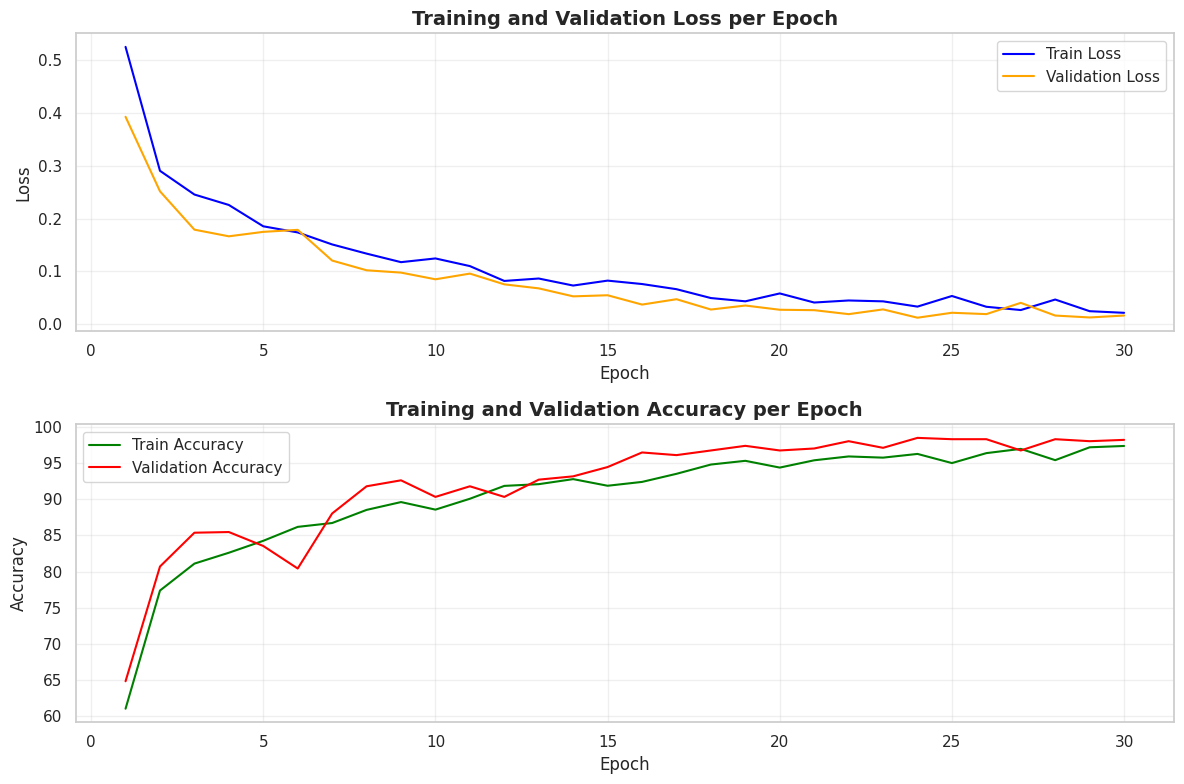

In [40]:
#metrics_path = f"{MODEL_SWINV2_SMALL}_metrics.csv"
#metrics_df = pd.read_csv(MODEL_SWINV2_SMALL_SAVE)

metrics_path = f"{MODEL_SWINV2_SMALL}_metrics.csv"
metrics_df = pd.read_csv('../input/model-swinv2/model_swinv2/swinv2.Csv')

# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure for visualizations
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
sns.lineplot(x='epoch', y='train_loss', data=metrics_df, label='Train Loss', color='blue')
sns.lineplot(x='epoch', y='val_loss', data=metrics_df, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
sns.lineplot(x='epoch', y='train_accuracy', data=metrics_df, label='Train Accuracy', color='green')
sns.lineplot(x='epoch', y='val_accuracy', data=metrics_df, label='Validation Accuracy', color='red')
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Adjust spacing between plots
plt.tight_layout()

# Save the visualization as a file with transparent background
#output_plot_path = f"{MODEL_SWINV2_SMALL}_training_visualization.png"
#plt.savefig(output_plot_path, dpi=300, transparent=True)
#print(f"Visualization saved to {output_plot_path}")

# Show the plots
plt.show()

In [41]:
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  
    return model

In [42]:
# Predict on validation data
def predict(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():  
        for inputs, labels in dataloader:  
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [46]:
# Define paths and device
#checkpoint_path = "/kaggle/working/model_swinv/swinv2_small_window16_256_epoch_24.pt"
checkpoint_path = "../input/model-swinv2/model_swinv2/model_swinv2/swinv2_small_window16_256_epoch_24.pt"
model_class=5
model = load_model_from_checkpoint(checkpoint_path, model_class, device)

y_true_train, y_pred_train = predict(model, train_loader, device)
y_true_val, y_pred_val = predict(model, val_loader, device)

<ipython-input-41-a62071619d40>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [47]:
train_accuracy= accuracy_score(y_true_train, y_pred_train)
Validation_accuracy = accuracy_score(y_true_val, y_pred_val)
print(f"Train Accuracy: {round(train_accuracy * 100, 2)}%")
print(f"Validation Accuracy: {round(Validation_accuracy * 100, 2)}%")

Train Accuracy: 98.35%
Validation Accuracy: 98.16%


In [48]:
# Generate Classification Report
report = classification_report(y_true_val, y_pred_val, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       336
           1       0.96      0.99      0.97       204
           2       0.99      0.93      0.96       212
           3       0.93      0.99      0.96        94
           4       0.99      1.00      0.99       242

    accuracy                           0.98      1088
   macro avg       0.97      0.98      0.98      1088
weighted avg       0.98      0.98      0.98      1088



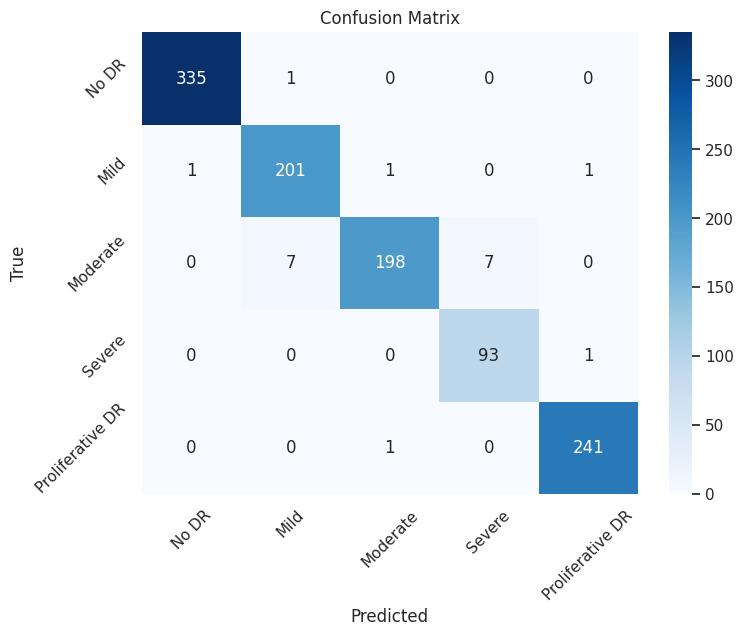

In [49]:
cm = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_title[str(i)] for i in range(cm.shape[0])], 
            yticklabels=[label_title[str(i)] for i in range(cm.shape[0])])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('confusion_matrix_swin', dpi=300, transparent=True)

plt.show()

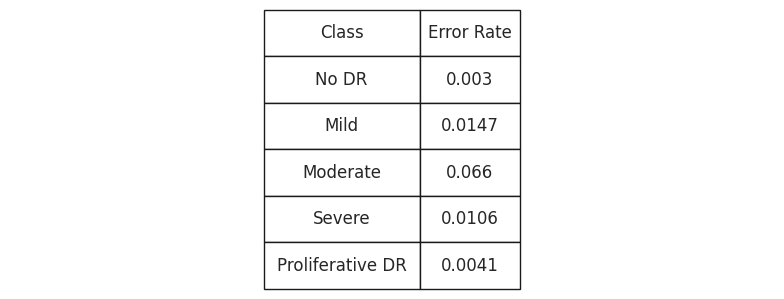

In [50]:
# Calculate errors per class (misclassifications)
class_errors = {}
num_classes = cm.shape[0]

for i in range(num_classes):
    total = np.sum(cm[i, :])  # Total number of instances of class i
    incorrect = total - cm[i, i]  # Misclassified instances of class i
    error_rate = incorrect / total if total != 0 else 0
    class_errors[label_title[str(i)]] = round(error_rate, 4)  # Round error_rate and map to class name

# Create a DataFrame for the error rates
error_data = pd.DataFrame(list(class_errors.items()), columns=['Class', 'Error Rate'])

fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('off')  # Turn off axis for the table

# Create and display the table, making it fill the figure
table = ax.table(cellText=error_data.values, colLabels=error_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(error_data.columns))))
table.scale(20, 5)  # Scale table size (adjust the values as needed)
plt.savefig('table_error_rate_swin', dpi=300, transparent=True)

plt.tight_layout()
plt.show()

In [ ]:
!cd /kaggle/working/
!zip -r model_swinv2.zip model_swinv2 swinv2_small_window16_256_training_visualization.png swinv2.Csv

In [ ]:
from IPython.display import FileLink
FileLink(r'model_swinv2.zip')

# MODEL_FastVit

In [63]:
model= timm.create_model(MODEL_FastVit, pretrained=True, num_classes=5)
weights_tensor = torch.tensor(list(class_weight_dict.values())).float()
criterion= nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer= optim.AdamW(model.parameters(), lr=LEARNING_RATE)

if USE_AMP:
    from torch.cuda import amp
    scaler = torch.amp.GradScaler()

model.safetensors:   0%|          | 0.00/38.1M [00:00<?, ?B/s]

In [ ]:
# Initialize lists to store metrics
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Record start time
start_time = time.time()

# Total number of batches for training and validation across all epochs
total_train_batches = len(train_loader) * EPOCHS
total_val_batches = len(val_loader) * EPOCHS
total_batches = total_train_batches + total_val_batches

# Start epoch loop with a single tqdm progress bar for the entire training process
with tqdm(total=total_batches, desc="Training Progress", unit="batch") as pbar:
    for epoch in range(EPOCHS):
        
        # Perform training step
        train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
        train_loss.append(train_metrics["loss"])
        train_accuracy.append(train_metrics["accuracy"])

        # Update progress bar after training for the current epoch
        pbar.set_postfix({
            "Train Loss": f"{train_metrics['loss']:.4f}",
            "Train Acc": f"{train_metrics['accuracy']:.2f}%",
            "Stage": "Train"
        })
        pbar.update(len(train_loader))  # Update progress bar by the number of batches in the training loader

        # Perform validation step
        val_metrics = val_step(model, val_loader, criterion, device)
        val_loss.append(val_metrics["loss"])
        val_accuracy.append(val_metrics["accuracy"])

        # Update progress bar after validation for the current epoch
        pbar.set_postfix({
            "Val Loss": f"{val_metrics['loss']:.4f}",
            "Val Acc": f"{val_metrics['accuracy']:.2f}%",
            "Stage": "Val"
        })
        pbar.update(len(val_loader))  # Update progress bar by the number of batches in the validation loader

        # Print epoch summary (not per-batch)
        print(f"Epoch {epoch+1} Summary:")
        print(f"Training loss = {train_metrics['loss']:.4f}, Training accuracy = {train_metrics['accuracy']:.2f}%")
        print(f"Validation loss = {val_metrics['loss']:.4f}, Validation accuracy = {val_metrics['accuracy']:.2f}%")

        # Save model checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_MODEL_FastVit_DIR, f"{MODEL_FastVit}_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), checkpoint_path)

# Record end time
end_time = time.time()

# Calculate total training time
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    "epoch": range(1, EPOCHS + 1),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
})

# Save the DataFrame to CSV
metrics_df.to_csv(MODEL_FastVit_SAVE, index=False)
print("Training metrics saved to CSV.")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

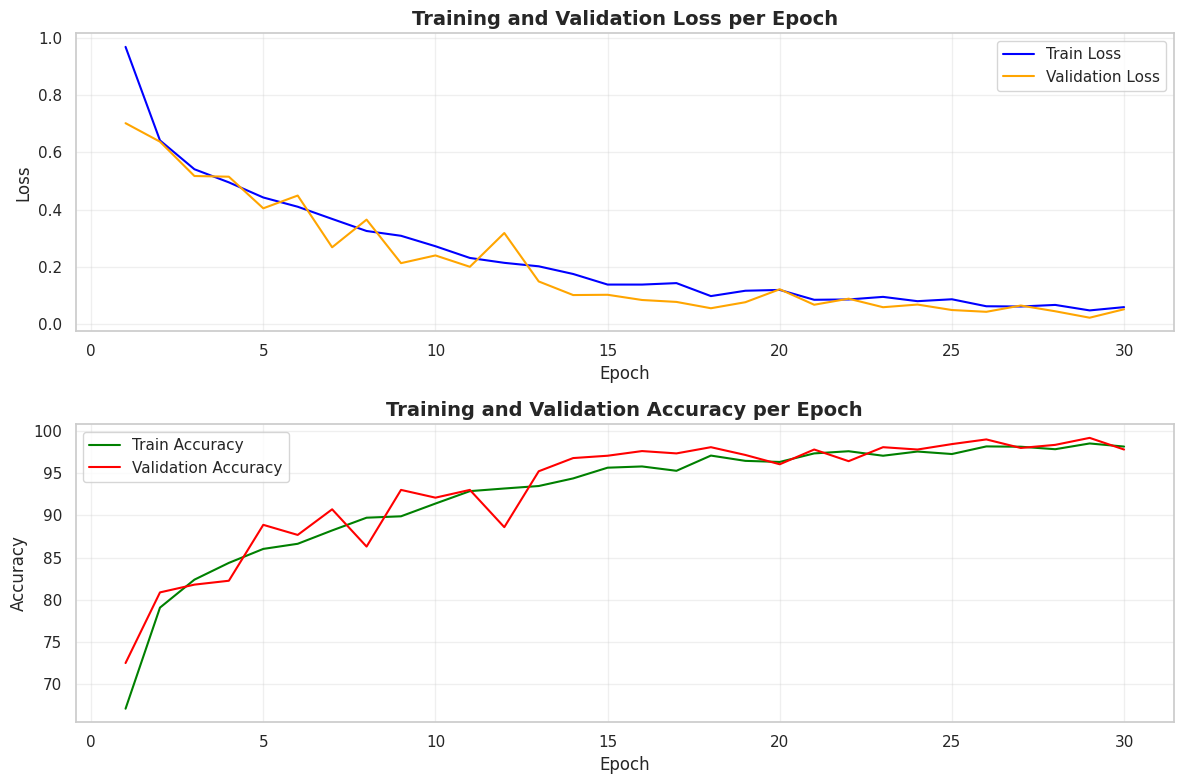

In [64]:
#metrics_path = f"{MODEL_FastVit}_metrics.csv" 
#metrics_df = pd.read_csv(MODEL_FastVit_SAVE)

metrics_path = f"{MODEL_FastVit}_metrics.csv"
metrics_df = pd.read_csv('../input/model-fastvit/model_fastvit/fastvit_s12.Csv')

# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure for visualizations
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
sns.lineplot(x='epoch', y='train_loss', data=metrics_df, label='Train Loss', color='blue')
sns.lineplot(x='epoch', y='val_loss', data=metrics_df, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
sns.lineplot(x='epoch', y='train_accuracy', data=metrics_df, label='Train Accuracy', color='green')
sns.lineplot(x='epoch', y='val_accuracy', data=metrics_df, label='Validation Accuracy', color='red')
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Adjust spacing between plots
plt.tight_layout()

# Save the visualization as a file with transparent background
#output_plot_path = f"{MODEL_FastVit}_training_visualization.png"
#plt.savefig(output_plot_path, dpi=300, transparent=True)
#print(f"Visualization saved to {output_plot_path}")

# Show the plots
plt.show()

In [65]:
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  
    return model

In [66]:
# Predict on validation data
def predict(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():  
        for inputs, labels in dataloader:  
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [69]:
# Define paths and device
checkpoint_path = "../input/model-fastvit/model_fastvit/model_fastvit/fastvit_s12_epoch_29.pt"
model_class=5
model = load_model_from_checkpoint(checkpoint_path, model_class, device)

y_true_train, y_pred_train = predict(model, train_loader, device)
y_true_val, y_pred_val = predict(model, val_loader, device)

<ipython-input-65-a62071619d40>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [70]:
train_accuracy= accuracy_score(y_true_train, y_pred_train)
Validation_accuracy = accuracy_score(y_true_val, y_pred_val)
print(f"Train Accuracy: {round(train_accuracy * 100, 2)}%")
print(f"Validation Accuracy: {round(Validation_accuracy * 100, 2)}%")

Train Accuracy: 99.03%
Validation Accuracy: 98.99%


In [71]:
# Generate Classification Report
report = classification_report(y_true_val, y_pred_val, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       0.99      0.99      0.99       219
           2       0.99      0.97      0.98       188
           3       0.94      1.00      0.97        63
           4       0.99      1.00      0.99       238

    accuracy                           0.99      1088
   macro avg       0.98      0.99      0.99      1088
weighted avg       0.99      0.99      0.99      1088



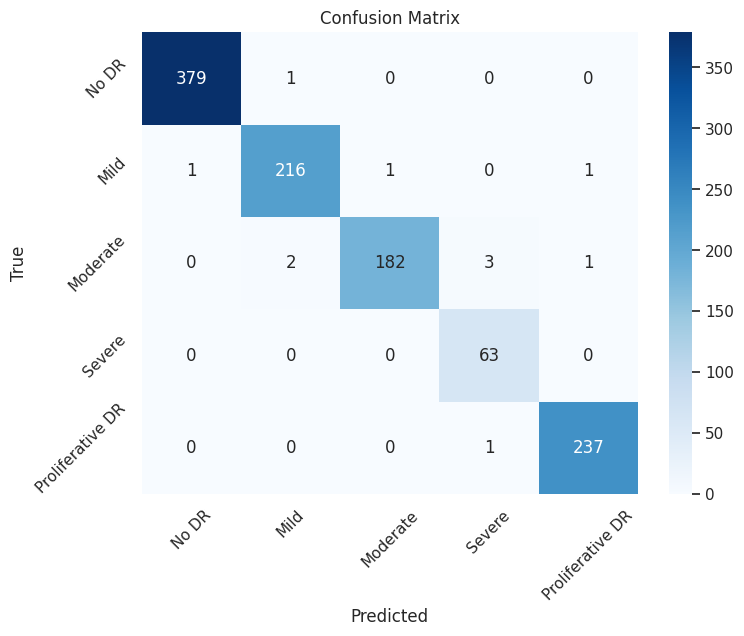

In [72]:
cm = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_title[str(i)] for i in range(cm.shape[0])], 
            yticklabels=[label_title[str(i)] for i in range(cm.shape[0])])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('confusion_matrix_fastvit', dpi=300, transparent=True)

plt.show()

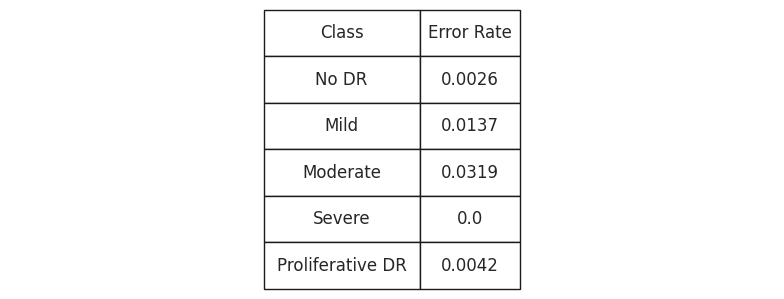

In [74]:
# Calculate errors per class (misclassifications)
class_errors = {}
num_classes = cm.shape[0]

for i in range(num_classes):
    total = np.sum(cm[i, :])  # Total number of instances of class i
    incorrect = total - cm[i, i]  # Misclassified instances of class i
    error_rate = incorrect / total if total != 0 else 0
    class_errors[label_title[str(i)]] = round(error_rate, 4)  # Round error_rate and map to class name

# Create a DataFrame for the error rates
error_data = pd.DataFrame(list(class_errors.items()), columns=['Class', 'Error Rate'])

fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('off')  # Turn off axis for the table

# Create and display the table, making it fill the figure
table = ax.table(cellText=error_data.values, colLabels=error_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(error_data.columns))))
table.scale(20, 5)  # Scale table size (adjust the values as needed)
plt.savefig('table_error_rate_fastvit', dpi=150, transparent=True)

plt.tight_layout()
plt.show()

In [ ]:
!cd /kaggle/working/
!zip -r model_fastvit.zip model_fastvit fastvit_s12_training_visualization.png confusion_matrix_fastvit.png fastvit_s12.Csv table_error_rate_fastvit.png

In [ ]:
from IPython.display import FileLink
FileLink(r'model_fastvit.zip')